Script to pull data from the Synoptic API for multiple surface stations and compare them against the URMA archive. Previously used to asess issues with URMA precip falling short of observed, can be used going forward to evaluate the final URMA archive or to aid in verifying NBM against observations... the framework is all here, just needs to be taken over the finish line for that.

In [1]:
import sys
sys.path.insert(1, '../scripts/')

import os
import csv
import requests
import nbm_funcs
import matplotlib

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import multiprocessing as mp

import seaborn as sns
import scipy.stats as scipy
import urllib.request as req
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

os.environ["OMP_NUM_THREADS"] = "1"

In [513]:
# NBM 1D Viewer Site to use
site = nbm_funcs._site = 'KSLC'

# Data Range
lead_time_end = 180
init_hours = nbm_funcs._init_hours = [0, 6, 12, 18]#[1, 7, 13, 19]

date0 = start_date = nbm_funcs._date0 = datetime(2020, 11, 1, 0, 0)
date1 = end_date = nbm_funcs._date1 = datetime(2021, 2, 1, 0, 0)

In [514]:
# datadir = nbm_funcs._datadir = '../archive/%s/data/'%site
datadir = nbm_funcs._datadir = '../archive/data/'
os.makedirs(datadir, exist_ok=True)

dates = nbm_funcs._dates = pd.date_range(date0, date1, freq='1D')
date2 = nbm_funcs._date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, init_hours, date0, date1, date2))


Forecast Site: KSLC
Init Hours: [0, 6, 12, 18]
First Init: 2020-11-01 00:00:00
Last Init: 2021-02-01 00:00:00
Last Verif: 2021-02-08 12:00:00


In [515]:
# Get metadata for the select point
meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'
meta_site = '&stid=%s&complete=1'%site
url = meta_base + api_token + meta_site
# print(url)

site_meta_raw = requests.get(url).json()
# print(meta_raw['STATION'][0])

zone = site_meta_raw['STATION'][0]['NWSZONE']
cwa = site_meta_raw['STATION'][0]['CWA']

print('Site: %s\nCWA: %s\nZone: %s'%(site, cwa, zone))

Site: KSLC
CWA: SLC
Zone: UT105


In [516]:
# Get a list of sites in the CWA that report precip
precip_base = 'https://api.synopticdata.com/v2/stations/precip?&complete=1&interval=6'
zone_query = '&nwszone=%s'%zone
cwa_query = '&cwa=%s'%cwa
date_query = '&start=%s&end=%s'%(
    date0.strftime('%Y%m%d%H%M'),
    (date0+timedelta(hours=6)).strftime('%Y%m%d%H%M'))

# We could query for a list of relevant zones within a CWA here
# Then pass a list of zones to the zone query
# !Add later!

# Fix this later! Temp fix to expand the zone for more NWS/FAA/RAWS stations
# Due to 1D Viewer file limitation - Ask Chad for advice?
zone_query = cwa_query

url = precip_base + api_token + zone_query + date_query
zone_meta_raw = requests.get(url).json()

meta = []
for station in zone_meta_raw['STATION']:
    
#     We need to get back to a zone query - for now this will work with a CWA query to only hit sites that exist within a CWA    
    if (('NWS' in station['SHORTNAME']) | ('RAWS' in station['SHORTNAME']) & (station['STID'][0] == 'K')):
        meta.append({k:station[k] for k in station.keys() if type(station[k]) == str})
        
meta = pd.DataFrame(meta).set_index('STID')

for k in meta:
    try:
        meta[k] = meta[k].astype(float)
    except:
        pass

meta

,NWSFIREZONE,ELEV_DEM,TIMEZONE,SGID,SHORTNAME,ELEVATION,GACC,STATUS,LONGITUDE,COUNTY,STATE,CWA,NWSZONE,ID,MNET_ID,NAME,COUNTRY,LATITUDE
STID,,,,,,,,,,,,,,,,,,
KSLC,SLC478,4235.6,America/Denver,GB25,NWS/FAA,4226.0,GBCC,ACTIVE,-111.96503,Salt Lake,UT,SLC,UT105,53.0,1.0,"Salt Lake City, Salt Lake City International A...",US,40.77069
KU42,SLC478,4603.0,America/Denver,GB25,NWS/FAA,4596.0,GBCC,ACTIVE,-111.99016,Salt Lake,UT,SLC,UT105,54.0,1.0,"Salt Lake City, Salt Lake City Municipal 2 Air...",US,40.61960
KHIF,SLC478,4799.9,America/Denver,GB25,NWS/FAA,4783.0,GBCC,ACTIVE,-111.96229,Davis,UT,SLC,UT104,55.0,1.0,Hill Air Force Base,US,41.11112
KOGD,SLC478,4452.1,America/Denver,GB25,NWS/FAA,4440.0,GBCC,ACTIVE,-112.01681,Weber,UT,SLC,UT104,56.0,1.0,Ogden-Hinckley Airport,US,41.19406
KPVU,SLC478,4498.0,America/Denver,GB25,NWS/FAA,4498.0,GBCC,ACTIVE,-111.71667,Utah,UT,SLC,UT106,58.0,1.0,"Provo, Provo Municipal Airport",US,40.21667
KLGU,SLC479,4442.3,America/Denver,GB26,NWS/FAA,4446.0,GBCC,ACTIVE,-111.85187,Cache,UT,SLC,UT107,59.0,1.0,Logan-Cache Airport,US,41.78652
KPUC,SLC489,5833.3,America/Denver,GB31,NWS/FAA,5813.0,GBCC,ACTIVE,-110.75548,Carbon,UT,SLC,UT120,60.0,1.0,Price - Carbon County Regional Airport,US,39.60886
KBCE,SLC496,7578.7,America/Denver,GB34,NWS/FAA,7585.0,GBCC,ACTIVE,-112.14897,Garfield,UT,SLC,UT127,100.0,1.0,Bryce Canyon Airport,US,37.70128
KCDC,SLC496,5593.8,America/Denver,GB33,NWS/FAA,5581.0,GBCC,ACTIVE,-113.09695,Iron,UT,SLC,UT122,128.0,1.0,Cedar City Municipal Airport,US,37.70675


In [517]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)
# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
zones = zones[zones['CWA'] == cwa]

# zones.to_file(geodir + 'forecast-zones.json', driver = 'GeoJSON')

In [518]:
# Single-process
ob_files = [nbm_funcs.get_precip_obs_mp(i) for i in meta.index.values]
ob_files = [f for f in ob_files if f is not None]

# Multi-process (needs fixing...)
# with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
#     ob_files = p.map_async(nbm_funcs.get_precip_obs_mp, meta.index.values, chunksize=1)
#     ob_files.wait()
# ob_files = [f for f in ob_files.get() if f is not None]

obs = []
for file in ob_files:
    site = file.split('/')[-1].split('_')[0]
    iobs = pd.read_pickle(file)
    iobs['Site'] = np.full(iobs.index.size, fill_value=site, dtype='U10')
    iobs = iobs.reset_index().set_index(['ValidTime', 'Site'])
    obs.append(iobs)
    
obs = pd.concat(obs).sort_index()

mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

# OPTIONAL! Drop NaN rows... may help elim lower qual dataw
# obs = obs.dropna(how='all')

sites = np.unique(obs.index.get_level_values(1))

print(obs.shape)
obs.head(10)

(6561, 3)


6h_precip_in  12h_precip_in  24h_precip_in
ValidTime  Site                                            
2020-11-02 K74V           0.0            0.0            0.0
           KBCE           0.0            0.0            0.0
           KCDC           0.0            0.0            0.0
           KENV           0.0            0.0            0.0
           KEVW           0.0            0.0            0.0
           KHIF           0.0            0.0            0.0
           KKNB           0.0            0.0            0.0
           KLGU           0.0            0.0            0.0
           KMLF           0.0            0.0            0.0
           KOGD           0.0            0.0            0.0

In [519]:
obs.describe().T

,count,mean,std,min,25%,50%,75%,max
6h_precip_in,6522.0,0.003124,0.019958,0.0,0.0,0.0,0.0,0.400984
12h_precip_in,6505.0,0.006259,0.032100,0.0,0.0,0.0,0.0,0.461000
24h_precip_in,6528.0,0.012476,0.050053,0.0,0.0,0.0,0.0,0.663000


In [520]:
obs24 = obs[['24h_precip_in']]
obs24

24h_precip_in
ValidTime           Site               
2020-11-02 00:00:00 K74V            0.0
                    KBCE            0.0
                    KCDC            0.0
                    KENV            0.0
                    KEVW            0.0
...                                 ...
2021-02-08 12:00:00 KSGU            0.0
                    KSLC            0.0
                    KTVY            0.0
                    KU42            0.0
                    KU55            0.0

[6561 rows x 1 columns]

In [521]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
os.makedirs(tmp_dir, exist_ok=True)

In [522]:
urma24 = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')

urma24 = urma24['apcp24h_mm'] / 25.4
urma24 = urma24.rename('apcp24h_in')
urma24['lon'] = urma24['lon'] - 360

In [523]:
# Time match
urma24t = np.array([pd.to_datetime(t) for t in urma24.valid.values])
urma24t = urma24t[(urma24t >= start_date)&(urma24t <= end_date)]

obs24t = np.unique(np.array(
    [pd.to_datetime(t) for t in obs24.index.get_level_values(0)]))

urma24 = urma24.sel(valid=urma24t[np.isin(urma24t, obs24t)])
obs24 = obs24.loc[obs24t[np.isin(obs24t, urma24t)]]

In [524]:
# All stats
err_stats_keys = ['site', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

print('URMA - Observed (Positive: URMA Wet, Negative: URMA Dry)\n')

for k in err_stats_keys:
    print(k, end='\t')
print()

# Site match
agg_bias = []
for stn in meta.index:

    stn_meta = meta.loc[stn]
    stn_lat, stn_lon = stn_meta['LATITUDE'], stn_meta['LONGITUDE']

    stn_obs24 = obs24.reset_index().set_index('Site').loc[stn].reset_index()
    stn_obs24 = stn_obs24.set_index('ValidTime').drop(columns='Site').sort_index()

    a = abs(urma24.lat-stn_lat) + abs(urma24.lon-stn_lon)
    i, j = np.unravel_index(a.argmin(), a.shape)
    stn_urma24 = urma24.isel(y=i, x=j)

    t = stn_obs24.index
    y1, y1lab = stn_obs24.values.T[0], '%s METAR'%stn
    y2, y2lab = stn_urma24.values, 'URMA 2.5KM'
    
    if y1.size == y2.size:
        
        # Remove NPEs
        y1[np.where((y1==0)&(y2==0))] = np.nan
        y2[np.where((y1==0)&(y2==0))] = np.nan

        err_stats = pd.Series(y2-y1).describe()

        agg_bias.append([err_stats['mean'], stn])

        print(stn, end='\t')
        for k in err_stats:
            print('%.2f'%np.round(k, 2), end='\t')
        print()
        
agg_bias = np.array(agg_bias)

URMA - Observed (Positive: URMA Wet, Negative: URMA Dry)

site	count	mean	std	min	25%	50%	75%	max	
KSLC	145.00	-0.00	0.01	-0.04	-0.01	-0.00	0.00	0.02	
KU42	120.00	0.04	0.06	-0.09	0.00	0.02	0.05	0.26	
KHIF	175.00	0.02	0.04	-0.06	-0.00	0.00	0.02	0.30	
KOGD	140.00	0.00	0.02	-0.09	-0.00	-0.00	0.01	0.10	
KPVU	146.00	-0.00	0.00	-0.01	-0.00	-0.00	-0.00	0.02	
KLGU	168.00	-0.01	0.02	-0.10	-0.01	-0.00	-0.00	0.03	
KPUC	87.00	0.00	0.01	-0.01	-0.00	-0.00	0.00	0.03	
KBCE	136.00	-0.00	0.02	-0.06	-0.01	-0.00	0.00	0.05	
KENV	69.00	-0.00	0.01	-0.03	-0.00	-0.00	-0.00	0.01	
KMLF	96.00	-0.00	0.03	-0.16	-0.01	-0.00	0.00	0.07	
KSGU	69.00	-0.02	0.07	-0.37	-0.01	-0.00	-0.00	0.03	
KEVW	173.00	0.00	0.05	-0.02	-0.01	-0.00	-0.00	0.36	
KKNB	70.00	0.05	0.04	0.00	0.01	0.04	0.08	0.15	
KU55	129.00	0.01	0.04	-0.12	0.00	0.00	0.02	0.14	
K74V	93.00	0.01	0.04	-0.12	0.00	0.00	0.02	0.11	
KTVY	104.00	0.06	0.05	0.00	0.01	0.03	0.11	0.20	


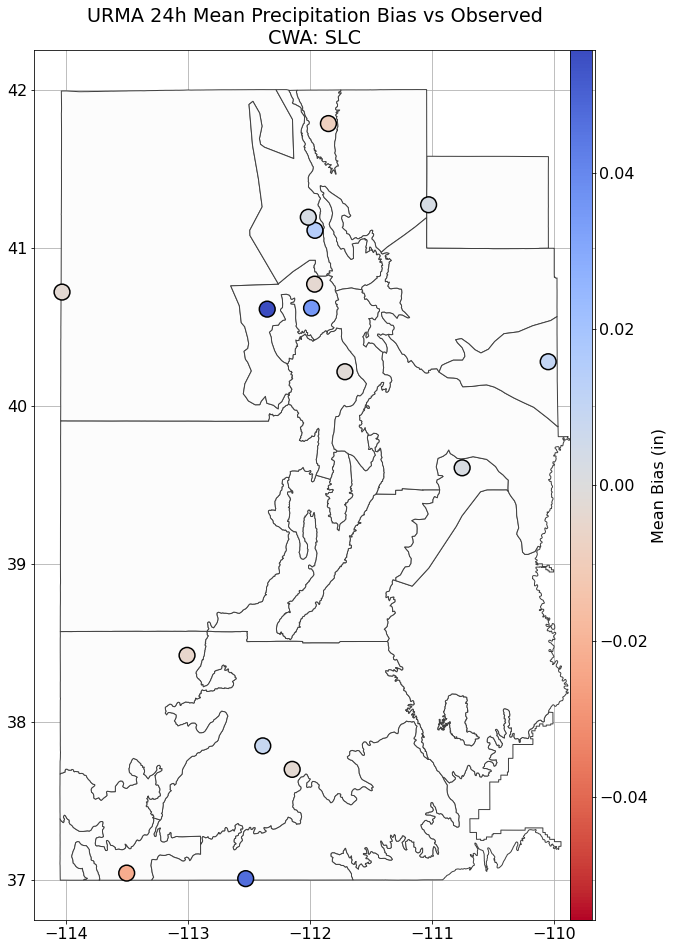

In [525]:
biastype = 'Mean'
cvals = agg_bias[:, 0].astype(np.float32)
maxdiff = max(abs(cvals.max()), abs(cvals.min()))

fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w')
ax.set_title('URMA 24h %s Precipitation Bias vs Observed\nCWA: %s'%(biastype, cwa))

zones.plot(column='NAME', color='0.99', edgecolor='0.25', ax=ax, zorder=10)

_meta = meta.loc[agg_bias[:, 1]]
cbd = ax.scatter(_meta['LONGITUDE'], _meta['LATITUDE'], c=cvals, cmap='coolwarm_r', 
                 s=250, marker='o', edgecolor='k', linewidth=1.5, zorder=20, vmin=maxdiff*-1, vmax=maxdiff)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5)
plt.colorbar(cbd, cax=cax, label='%s Bias (in)'%biastype)
ax.grid(True, zorder=-10)

fig.show()

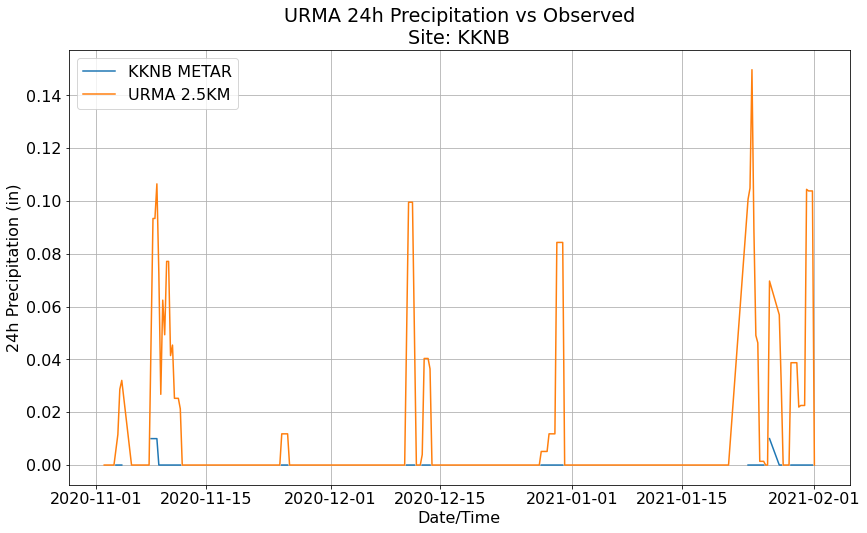

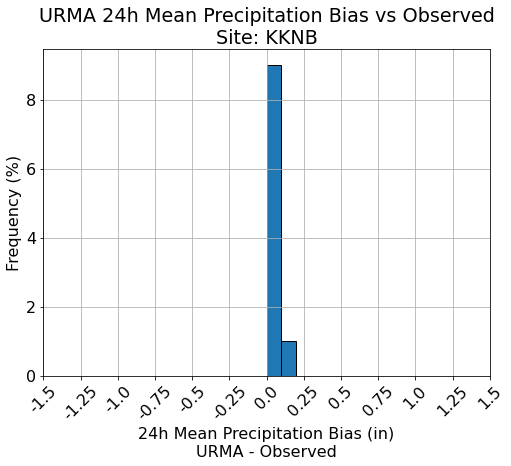

In [527]:
# Site match
stn = 'KKNB'
stn_meta = meta.loc[stn]
stn_lat, stn_lon = stn_meta['LATITUDE'], stn_meta['LONGITUDE']

stn, stn_lat, stn_lon

stn_obs24 = obs24.reset_index().set_index('Site').loc[stn].reset_index()
stn_obs24 = stn_obs24.set_index('ValidTime').drop(columns='Site').sort_index()

a = abs(urma24.lat-stn_lat) + abs(urma24.lon-stn_lon)
i, j = np.unravel_index(a.argmin(), a.shape)
stn_urma24 = urma24.isel(y=i, x=j)

t = stn_obs24.index
y1, y1lab = stn_obs24.values.T[0], '%s METAR'%stn
y2, y2lab = stn_urma24.values, 'URMA 2.5KM'

# Remove NPEs
y1[np.where((y1==0)&(y2==0))] = np.nan
y2[np.where((y1==0)&(y2==0))] = np.nan

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, figsize=(14, 8), facecolor='w')

ax.plot(t, y1, label=y1lab)
ax.plot(t, y2, label=y2lab)

ax.legend()
ax.grid()
ax.set_title('URMA 24h Precipitation vs Observed\nSite: %s'%(stn))
ax.set_xlabel('Date/Time')
ax.set_ylabel('24h Precipitation (in)')
plt.show()

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, figsize=(8, 6), facecolor='w')

ax.hist(y2-y1, bins=np.arange(-1.5, 1.5, .1), 
         density=True, edgecolor='k')

ax.set_xticks(np.arange(-1.5, 1.5+.25, .25))
ax.set_xticklabels(np.arange(-1.5, 1.5+.25, .25), rotation=45)
ax.set_xlim([-1.5, 1.5])

ax.set_title('URMA 24h %s Precipitation Bias vs Observed\nSite: %s'%(biastype, stn))
ax.set_xlabel('24h Mean Precipitation Bias (in)\nURMA - Observed')
ax.set_ylabel('Frequency (%)')

ax.grid()